# About

On previous notebooks we explore the data and we got into the conclusion that the size of the buildings is similar to the desired cell size of the cells to calculate stats (10x10m). This means that found the fraction of the building that match for each cell is critical to avoid no sense average values or assume that a building is only in one cell. 

On this notebook we will start defining the cells and assigning the buildings to the corresponding cells using some kind of geometry tools.

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt


In [5]:
# We load the testing data that belows to the city center (maybe we need to test later one outside the city center region where the data is not so dense)

data_folder = "Data/"
filename = "95b_buildings_target.csv"


geo_data = gpd.read_file(data_folder + filename)
geo_data['geometry'] = geo_data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(geo_data, geometry='geometry')
gdf.head()

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,-34.6097565,-58.37273245,137.163,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP
1,-34.60331185,-58.3882907,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG
2,-34.60667276,-58.38346319,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2
3,-34.606241,-58.37975464,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359
4,-34.60178779,-58.37226492,140.948,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG


In [7]:
gdf.dtypes # We need to convert the not 'geometry' columns dtypes

latitude            object
longitude           object
area_in_meters      object
confidence          object
geometry          geometry
full_plus_code      object
dtype: object

In [8]:
gdf["latitude"] = gdf["latitude"].astype(float)
gdf["longitude"] = gdf["longitude"].astype(float)
gdf["confidence"] = gdf["confidence"].astype(float)
gdf["area_in_meters"] = gdf["area_in_meters"].astype(float)
gdf["full_plus_code"] = gdf["full_plus_code"].astype(str)
gdf.dtypes

latitude           float64
longitude          float64
area_in_meters     float64
confidence         float64
geometry          geometry
full_plus_code      object
dtype: object

<Axes: >

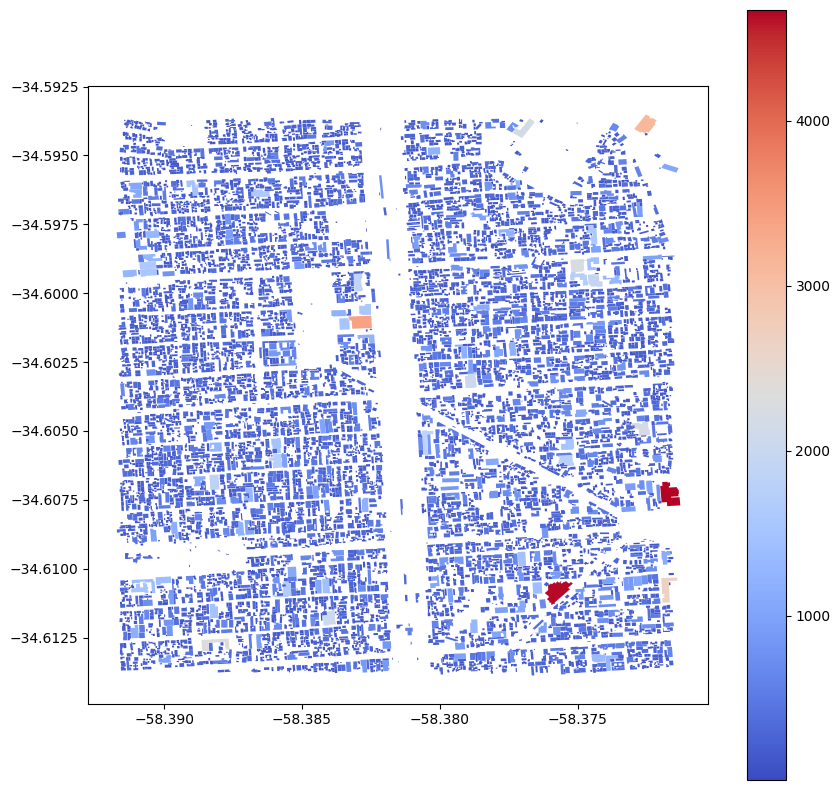

In [10]:
gdf.plot(column="area_in_meters", cmap="coolwarm", legend=True, figsize=(10, 10))

# Cells creation

We will create a grid of 10x10m cells over the area of interest, then we need to assign the buildings to all the corresponding cells. In order to do this we will assume that teh building has a "radious" equal to the max distance to the centroid of the building and then we will check all cells that are inside this radious. We will iterate over buildings because the cells are defined a priori, so we don't need to iterate over cells.



In [39]:
cell_size = 10 # 10 meters
cell_size_in_degrees = cell_size / 111320 # 1 degree is approximately 111.32 km

# We will create a naive long and lat coordinates relative to the center of the area that we want to analyze, this allows us to make easy the math to locate the corresponding cell with just a simple division.

area_center_lat = (gdf["latitude"].max() + gdf["latitude"].min()) / 2
area_center_lon = (gdf["longitude"].max() + gdf["longitude"].min()) / 2
gdf["relative_lat"] = gdf["latitude"] - area_center_lat
gdf["relative_lon"] = gdf["longitude"] - area_center_lon


# Now we could assign each building center to a coordinate pair on the grid just dividing the relative coordinates by the cell size in degrees and rounding down to the nearest integer

gdf["cell_lat"] = gdf["relative_lat"].floordiv(cell_size_in_degrees).astype(int)
gdf["cell_lon"] = gdf["relative_lon"].floordiv(cell_size_in_degrees).astype(int)

# We still need to know how much close cells could overlap with the building, so we will define the building size in terms of the cell size.

def calculate_polygon_size(polygon):
    # Calculate the size of the polygon in terms of the cell size
    min_x, min_y, max_x, max_y = polygon.bounds
    width = (max_x - min_x) / cell_size_in_degrees
    height = (max_y - min_y) / cell_size_in_degrees
    return max(width,height)/2

gdf["cells_size"] = gdf["geometry"].apply(calculate_polygon_size).astype(int) + 1 # We make +1 because we need to include at least one cell on each side in case that the building is close to the cell border. For example, in the case that the size (that is the max radius) is 0.79 cells, that means that we need to check all contiguous cells. In the case that the radius is 1.2 we need to check at least 2 cells on each side (and corners) because if the building center is very close to the cell border it could cross an entire cell on the side and reach the next one. 

gdf

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,relative_lat,relative_lon,cell_lat,cell_lon,cells_size
0,-34.609757,-58.372732,137.1630,0.7771,"POLYGON ((-58.37269 -34.60983, -58.37269 -34.6...",48Q39JRG+3WRP,-0.006034,0.008859,-68,98,1
1,-34.603312,-58.388291,23.7655,0.6978,"POLYGON ((-58.38826 -34.60333, -58.38827 -34.6...",48Q39JW6+MMGG,0.000411,-0.006699,4,-75,1
2,-34.606673,-58.383463,214.7212,0.7673,"POLYGON ((-58.38343 -34.60678, -58.38343 -34.6...",48Q39JV8+8JM2,-0.002950,-0.001872,-33,-21,2
3,-34.606241,-58.379755,218.6224,0.8731,"POLYGON ((-58.37969 -34.60634, -58.37972 -34.6...",48Q39JVC+G359,-0.002518,0.001837,-29,20,2
4,-34.601788,-58.372265,140.9480,0.7562,"POLYGON ((-58.37218 -34.60183, -58.37219 -34.6...",48Q39JXH+73QG,0.001935,0.009326,21,103,1
...,...,...,...,...,...,...,...,...,...,...,...
9627,-34.612691,-58.378285,99.3895,0.8269,"POLYGON ((-58.37821 -34.61272, -58.37821 -34.6...",48Q39JPC+WMG9,-0.008969,0.003307,-100,36,1
9628,-34.598224,-58.387981,197.2301,0.7845,"POLYGON ((-58.38791 -34.59828, -58.38792 -34.5...",48Q3CJ26+PR64,0.005499,-0.006390,61,-72,2
9629,-34.600833,-58.380258,37.6236,0.6620,"POLYGON ((-58.38022 -34.60086, -58.38023 -34.6...",48Q39JX9+MV9Q,0.002890,0.001334,32,14,1
9630,-34.611618,-58.389089,76.9883,0.7808,"POLYGON ((-58.38903 -34.61165, -58.38903 -34.6...",48Q39JQ6+9936,-0.007896,-0.007498,-88,-84,1


The advantage of this approach is that the scale of the calculations is O(n) because we will make just the calculations for each building independently of the size of the grid.

In [ ]:
# Now we will create a grid of polygons where each grid cell is a square of size cell_size x cell_size to check the overlap within the objects

def create_grid(x_min, x_max, y_min, y_max, cell_size):
    # Create a grid of polygons
    x_coords = list(range(int(x_min), int(x_max) + 1, cell_size))
    y_coords = list(range(int(y_min), int(y_max) + 1, cell_size))
    grid_polygons = []
    for x in x_coords:
        for y in y_coords:
            grid_polygons.append(((x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)))
    return grid_polygons

In [33]:
polygon = gdf["geometry"].iloc[0]

In [41]:
x_coords = list(range(int(-2), int(3) + 1, cell_size))
x_coords

[-2]

In [29]:
cell_size_in_degrees

8.983111749910169e-05

In [34]:
calculate_polygon_size(polygon)

1.798268752533204

In [24]:
print(polygon)

POLYGON ((-58.3726862870237 -34.6098345100679, -58.3726938558099 -34.609675731466, -58.3727786133432 -34.6096784933544, -58.3727710447186 -34.6098372719576, -58.3726862870237 -34.6098345100679))
